In [55]:
import time

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.10Ef' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

from impyute.imputation import cs
pd.options.display.float_format = '{:20,.15f}'.format

from pprint import pprint

In [56]:
# cols_to_exclude = ['genre__western', 'genre__documentary', 'genre__history', 'country__es', 'country__jp', 'country__ca', 'country__de', 'country__in', 'country__fr', 'country__ru', 'country__it', 'country__au', 'rating__nc-17', 'country__other', 'tag__satire', 'tag__neo_noir', 'tag__sadist', 'tag__cruelty', 'tag__dark', 'tag__storytelling', 'tag__sci_fi', 'tag__psychological', 'tag__absurd', 'tag__philosophical', 'tag__depressing', 'tag__plot_twist', 'tag__realism', 'tag__home_movie', 'tag__thought_provoking']
cols_to_exclude = []

def get_train_test_revenue(df):
    df['revenue'] = df['META__revenue']
    dff = df[[col for col in df.columns if not 'META' in col and not 'PROCESS' in col and not 'profitability' in col and col not in cols_to_exclude]]
    X = dff.drop(['revenue'], axis=1)
    y = dff['revenue']
    return X, y

In [57]:
df_raw = pd.read_csv('savedcsv/17_homepage.csv')
df = shuffle(df_raw)

num_in_train = int(df.shape[0]*0.8)
df_train = df[:num_in_train]
df_test = df[num_in_train:]
X_train, y_train = get_train_test_revenue(df_train)
X_test, y_test = get_train_test_revenue(df_test)

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [58]:
class Process:
    def __init__(self, 
                 X_train, X_test, y_train, y_test, 
                 imputer='mean', 
                 minmaxrange=(0,1), 
                 standardize_X=True,
                 standardize_y=True,
                ):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.y_train = y_train.copy().values.reshape(-1, 1)
        self.y_test = y_test.copy().values.reshape(-1, 1)
        self.imputer = imputer
        self.X_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.skewer_X = PowerTransformer(standardize=standardize_X)
        self.skewer_y = PowerTransformer(standardize=standardize_y)

    def fill_nan(self):
        def fill_train_test(imputer):
            imputer.fit(self.X_train)
            self.X_train[:] = imputer.transform(self.X_train)
            self.X_test[:] = imputer.transform(self.X_test)

        if (self.imputer == 'mean'):
            fill_train_test(SimpleImputer(strategy='mean'))
        elif (self.imputer == 'median'):
            fill_train_test(SimpleImputer(strategy='median'))
        elif (self.imputer == 'knn'):
            fill_train_test(KNNImputer())
        elif (self.imputer == 'iterative'):
            fill_train_test(IterativeImputer(verbose=0, max_iter=50))
        elif (self.imputer == 'iterative_mlp'):
            fill_train_test(
                IterativeImputer(
                    estimator=MLPRegressor(learning_rate='adaptive', random_state=0),
                    verbose=2,
                )
            )
        return self
        
    def minmaxscale_X(self):
        def scaler_transform(obj):
            return self.X_minmaxscaler.transform(obj)
        
        self.X_minmaxscaler.fit(self.X_train)
        self.X_train[:] = scaler_transform(self.X_train)
        self.X_test[:] = scaler_transform(self.X_test)
        return self
    
    def minmaxscale_X_inverse(self, data):
        return self.X_minmaxscaler.inverse_transform(data)
    
    def minmaxscale_Y(self, inverse=False):
        def scaler_transform(obj):
            return self.y_minmaxscaler.transform(obj)

        self.y_minmaxscaler.fit(self.y_train)
        self.y_train[:] = scaler_transform(self.y_train)
        self.y_test[:] = scaler_transform(self.y_test)
        return self
    
    def minmaxscale_Y_inverse(self, data): # data is in 1d array
        return self.y_minmaxscaler.inverse_transform(data.reshape(-1, 1)).flatten()
        
    
    def make_target_positive(self):
        self.min_y_train = min(self.y_train)
        self.y_train = self.y_train - self.min_y_train + 1
        self.y_test = self.y_test - self.min_y_train + 1
        return self
        
    def return_target_back_from_positive(self):
        self.y_train = self.y_train + self.min_y_train - 1
        self.y_test = self.y_test + self.min_y_train - 1
        return self
    
    def return_target_back_from_positive(self, obj):
        return obj + self.min_y_train - 1
    
    def skew_X(self, inverse=False):
        self.skewer_X.fit(self.X_train)
        self.X_train[:] = self.skewer_X.transform(self.X_train)
        self.X_test[:] = self.skewer_X.transform(self.X_test)
        return self
    
    def skew_X_inverse(self, data):
        return self.skewer_X.inverse_transform(data)
    
    def skew_y(self):
        self.skewer_y.fit(self.y_train)
        self.y_train = self.skewer_y.transform(self.y_train)
        self.y_test = self.skewer_y.transform(self.y_test)
        return self

    def skew_y_inverse(self, data): # data is 1d ndarray
        return self.skewer_y.inverse_transform(data.reshape(-1, 1)).flatten()

    def return_processed(self):
        return self.X_train, self.X_test, self.y_train.flatten(), self.y_test.flatten()       

In [59]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Lars
from sklearn.linear_model import LarsCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import NuSVR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

models = {
#     'AdaBoostRegressor': AdaBoostRegressor(),
#     'BaggingRegressor': BaggingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
#     'GradientBoostingRegressor': GradientBoostingRegressor(),
#     'RandomForestRegressor': RandomForestRegressor(),
#     'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
#     'GaussianProcessRegressor': GaussianProcessRegressor(),
#     'KernelRidge': KernelRidge(),
#     'ElasticNet': ElasticNet(),
#     'ElasticNetCV': ElasticNetCV(),
#     'Lars': Lars(),
#     'LarsCV': LarsCV(),
#     'Lasso': Lasso(),
#     'LassoCV': LassoCV(),
#     'LassoLarsCV': LassoLarsCV(),
#     'LassoLarsIC': LassoLarsIC(),
#     'HuberRegressor': HuberRegressor(),
#     'TheilSenRegressor': TheilSenRegressor(),
#     'KNNeighborsRegressor': KNeighborsRegressor(),
#     'MLPRegressor': MLPRegressor(),
#     'LinearSVR': LinearSVR(),
#     'NuSVR': NuSVR(),
#     'SVR': SVR(),
#     'SGDRegressor': SGDRegressor(),
#     'DecisionTreeRegressor': DecisionTreeRegressor(),
}
    

In [60]:
def get_metrics(y_test, y_pred, cols):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (float(SS_Residual))/SS_Total
    adj_r2 = 1 - (1-r2)*(len(y_test) - 1)/(len(y_test) - cols -1)
    return  {
        'mape': sum(abs((y_test - y_pred)/y_test)),
        'mae': metrics.mean_absolute_error(y_test, y_pred),
#         'mse': metrics.mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
#         'r2': r2,
        'adj_r2': adj_r2,
    }

def print_metrics(data, y_test, y_pred, cols):
    print(data)
    res = get_metrics(y_test, y_pred, cols)
    for key in res:
#         print(f'{key}: {res[key]}')
        print(res[key])
    return res

def predict(model, model_name, X_train, y_train, X_test, y_test):
    print()
    print(model_name)
    model.fit(X_train.values, y_train)
    pred_train = model.predict(X_train.values)
    pred_test = model.predict(X_test.values)
    return {
        'res': {
            'train': print_metrics('train', y_train, pred_train, X_train.shape[1]),
            'test': print_metrics('test', y_test, pred_test, X_test.shape[1]),
        },
        'predictions':{
            'train': pred_train,
            'test': pred_test,
        },
        'actual': {
            'train': y_train,
            'test': y_test,
        },
    }


def predict_test(X_train, y_train, X_test, y_test):
    prediction_results = {}
    for model in models:
        prediction_results[model] = predict(models[model], model, X_train, y_train, X_test, y_test)
    return prediction_results

# ---------------------------------------------------------------------
def print_graphs(actual, predicted, print_log=False):
    length = len(actual)
    res_df = pd.DataFrame({'actual':actual, 'predicted': predicted}).astype(float)
    res_df.sort_values(by='actual', inplace=True)

    plt.figure()
    x = np.linspace(0, length, length)
    plt.plot(x, res_df['actual'], label='actual')
    plt.plot(x, res_df['predicted'], label='predicted')

    plt.ticklabel_format(useOffset=False, style='plain')
    plt.rcParams["figure.figsize"] = (8,8)
    if print_log:
        plt.yscale('log')
    plt.show()
    
def print_sorted_actual_to_predicted_graphs(res, process=None, train_log=False, test_log=False):
    for i in res:
        print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
        print(i)
        print('train')
        print_graphs(res[i]['actual']['train'], res[i]['predictions']['train'], print_log=train_log)
        print('test')        
        print_graphs(res[i]['actual']['test'], res[i]['predictions']['test'], print_log=train_log)
        
        if process:
            train_real = process.skew_y_inverse(res[i]['actual']['train'])
            test_real = process.skew_y_inverse(res[i]['actual']['test'])
            pred_train_real = process.skew_y_inverse(res[i]['predictions']['train'])
            pred_test_real = process.skew_y_inverse(res[i]['predictions']['test'])

            print('train real values log')
            print_graphs(train_real, pred_train_real, print_log=True)
            print('test real values log')
            print_graphs(test_real, pred_test_real, print_log=True)
            print('train real values')
            print_graphs(train_real, pred_train_real)
            print('test real values')
            print_graphs(test_real, pred_test_real)
            
            
# ------------------------------------------------------------------
n_folds = 10
scoring = ['neg_mean_squared_error', 'explained_variance', 'r2', 'neg_mean_absolute_error']
def cv(model, X, y):
    return cross_validate(model, X.values, y, scoring=scoring, cv=10, n_jobs=-1)

def eval_model(model, name, X, y):
    start_time = time.time()
    score = cv(model, X, y)
    print('-------------------------------')
    print(name)
    means = {}
    for parameter in score:
        means[parameter] = score[parameter].mean()
        print(f'{parameter}: {means[parameter]}')
    return means

In [61]:
data = {}
process = Process(X_train, X_test, y_train, y_test, imputer='knn').skew_X().minmaxscale_X().fill_nan()
Xh_train, Xh_test, yh_train, yh_test = process.return_processed()
data['X_train'] = Xh_train
data['X_test'] = Xh_test
data['y_train'] = yh_train
data['y_test'] = yh_test

KeyboardInterrupt: 

In [118]:
results = {}
for model in models:
    results[model] = eval_model(models[model], model, data['X_train'], data['y_train'])

# print_sorted_actual_to_predicted_graphs(results)


metrics = ['test_neg_mean_squared_error', 'test_explained_variance', 'test_r2', 'test_neg_mean_absolute_error']
best_metrics = {m:{'val': -np.inf} for m in metrics}

for model in results:
    for metric in metrics:
        value = results[model][metric]
        if value > best_metrics[metric]['val']:
            best_metrics[metric]['val'] = value
            best_metrics[metric]['model'] = model

from pprint import pprint
pprint(best_metrics)

-------------------------------
AdaBoostRegressor
fit_time: 13.330416560173035
score_time: 0.06489403247833252
test_neg_mean_squared_error: -4.180962896006133e+16
test_explained_variance: 0.5295583677364727
test_r2: -0.6568427805182979
test_neg_mean_absolute_error: -188083156.37123954
-------------------------------
BaggingRegressor
fit_time: 16.63390157222748
score_time: 0.01578848361968994
test_neg_mean_squared_error: -1.0586280556695274e+16
test_explained_variance: 0.6100377871255225
test_r2: 0.6081862666337198
test_neg_mean_absolute_error: -49584174.098940566
-------------------------------
ExtraTreesRegressor
fit_time: 52.605335521697995
score_time: 0.044881224632263184
test_neg_mean_squared_error: -9229920325664254.0
test_explained_variance: 0.6645965810657312
test_r2: 0.6630245200124338
test_neg_mean_absolute_error: -45960148.246613145
-------------------------------
GradientBoostingRegressor
fit_time: 36.332259917259215
score_time: 0.0038856744766235353
test_neg_mean_squared_er

/home/stas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


-------------------------------
TheilSenRegressor
fit_time: 419.48023076057433
score_time: 0.005027890205383301
test_neg_mean_squared_error: -1.1672771369752866e+16
test_explained_variance: 0.5748474417453605
test_r2: 0.5739160655074432
test_neg_mean_absolute_error: -57474116.775612175
-------------------------------
KNNeighborsRegressor
fit_time: 0.545149302482605
score_time: 4.331003642082214
test_neg_mean_squared_error: -1.5570143681923892e+16
test_explained_variance: 0.44446965162173413
test_r2: 0.4318004321354952
test_neg_mean_absolute_error: -55506476.35529093
-------------------------------
MLPRegressor
fit_time: 50.68259720802307
score_time: 0.014557671546936036
test_neg_mean_squared_error: -3.3420426176923884e+16
test_explained_variance: 0.00019959080118798768
test_r2: -0.2326288456869774
test_neg_mean_absolute_error: -77811252.0251123
-------------------------------
LinearSVR
fit_time: 0.12759029865264893
score_time: 0.00816965103149414
test_neg_mean_squared_error: -3.3429547


ExtraTreesRegressor
train
0.0
0.0
0.0
1.0
test
44371.8835404614
44263255.8432355
83110753.74818835
0.6161904381817427
^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ExtraTreesRegressor
train


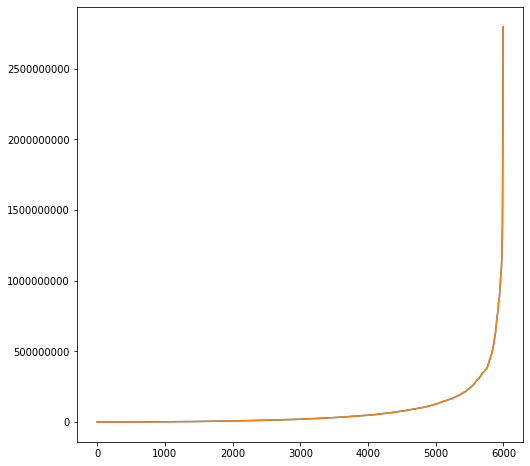

test


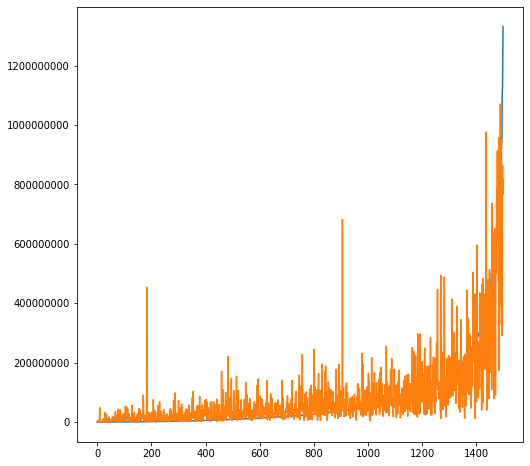

In [128]:
res2 = predict_test(data['X_train'], data['y_train'], data['X_test'], data['y_test'])
print_sorted_actual_to_predicted_graphs(res2)

In [ ]:
from sklearn.model_selection import GridSearchCV

model = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=500)
                            
gsc = GridSearchCV(
    estimator=model,
    param_grid={
        'max_features': [25, 50, 100, 150, 200, 225],
        'min_samples_leaf': [1, 5, 10, 15, 20, 30],
        'min_samples_split': [10, 25, 50, 100],
    },
    scoring='r2',
    cv=5
)

grid_result = gsc.fit(Xh_train, yh_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


for test_mean, param in zip(
        grid_result.cv_results_['mean_test_score'],
        grid_result.cv_results_['params']):
    print("Test : %f with: %r" % (test_mean, param))

In [40]:
from sklearn.model_selection import GridSearchCV

model = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=5000, min_samples_leaf=5, min_samples_split=10)
                            
gsc = GridSearchCV(
    estimator=model,
    param_grid={
#         'n_estimators': [10, 100, 500, 1000, 5000],
        'max_features': [25, 50, 100, 125, 150, 175, 200, 225],
#         'min_samples_leaf': [1, 5, 10, 15, 20, 30],
#         'min_samples_split': [10, 25, 50, 100],
    },
    scoring='r2',
    cv=5
)

grid_result = gsc.fit(Xh_train, yh_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


for test_mean, param in zip(
        grid_result.cv_results_['mean_test_score'],
        grid_result.cv_results_['params']):
    print("Test : %f with: %r" % (test_mean, param))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   19.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 498

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   34.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 4034 tasks     

[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using back

[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 5000 out of 500

[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4985 out of 5000 | elapsed:  1.8min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4985 out of 5000 | elapsed:  2.1min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Paral

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 

Best: 0.643857 using {'max_features': 200}
Test : 0.589763 with: {'max_features': 25}
Test : 0.615657 with: {'max_features': 50}
Test : 0.635385 with: {'max_features': 100}
Test : 0.639522 with: {'max_features': 125}
Test : 0.641949 with: {'max_features': 150}
Test : 0.643614 with: {'max_features': 175}
Test : 0.643857 with: {'max_features': 200}
Test : 0.643836 with: {'max_features': 225}


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.7min finished


In [18]:
grid_result.best_params_

{'max_features': 225, 'min_samples_leaf': 1, 'min_samples_split': 10}

In [21]:
t = {}
for test_mean, param in zip(
        grid_result.cv_results_['mean_test_score'],
        grid_result.cv_results_['params']):
    t[test_mean] = param

In [23]:
pprint(sorted(t.items()))

[(0.4969653254621278,
  {'max_features': 25, 'min_samples_leaf': 30, 'min_samples_split': 100}),
 (0.5057615433728033,
  {'max_features': 25, 'min_samples_leaf': 30, 'min_samples_split': 25}),
 (0.5059406273083933,
  {'max_features': 25, 'min_samples_leaf': 30, 'min_samples_split': 50}),
 (0.5082879966364648,
  {'max_features': 25, 'min_samples_leaf': 30, 'min_samples_split': 10}),
 (0.5100929976776758,
  {'max_features': 25, 'min_samples_leaf': 20, 'min_samples_split': 100}),
 (0.5186185553575168,
  {'max_features': 25, 'min_samples_leaf': 15, 'min_samples_split': 100}),
 (0.5237105624522517,
  {'max_features': 25, 'min_samples_leaf': 10, 'min_samples_split': 100}),
 (0.5283105539549444,
  {'max_features': 25, 'min_samples_leaf': 20, 'min_samples_split': 50}),
 (0.5306832423725595,
  {'max_features': 25, 'min_samples_leaf': 20, 'min_samples_split': 10}),
 (0.5312695666599604,
  {'max_features': 25, 'min_samples_leaf': 20, 'min_samples_split': 25}),
 (0.5319180782743722,
  {'max_featur


ExtraTreesRegressor


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 

train
217445.9756428028
33153947.30900328
73900460.58233865
0.7852580832850763
test
63757.3913014841
44242140.380571395
92651763.65044078
0.6282917821424019
^^^^^^^^^^^^^^^^^^^^^^^^^^^^
etr
train


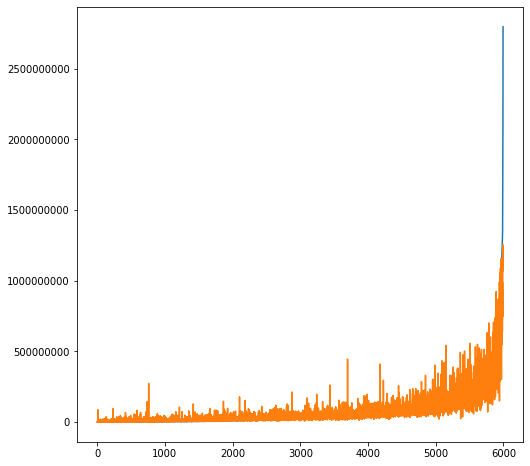

test


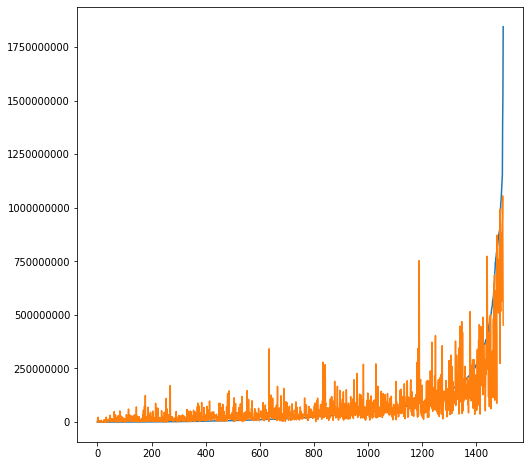

^^^^^^^^^^^^^^^^^^^^^^^^^^^^
etr
train


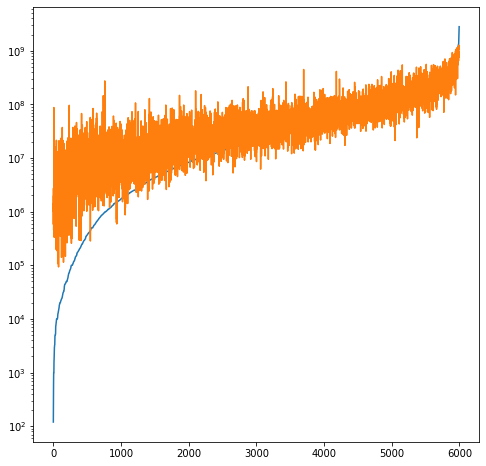

test


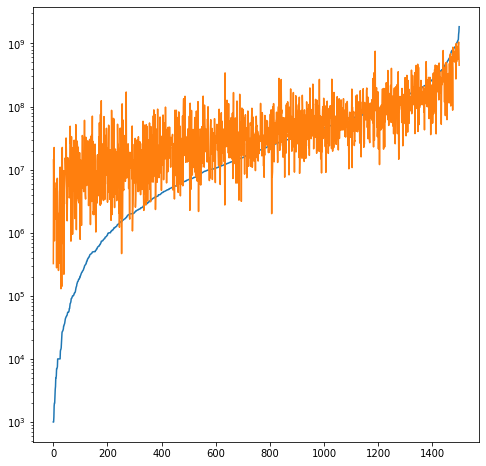

In [34]:
etr = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=10000, max_features=200, min_samples_leaf=10, min_samples_split=25)
res3 = predict(etr, "ExtraTreesRegressor", Xh_train, yh_train, Xh_test, yh_test)
print_sorted_actual_to_predicted_graphs({'etr': res3})
print_sorted_actual_to_predicted_graphs({'etr': res3}, train_log=True, test_log=True)

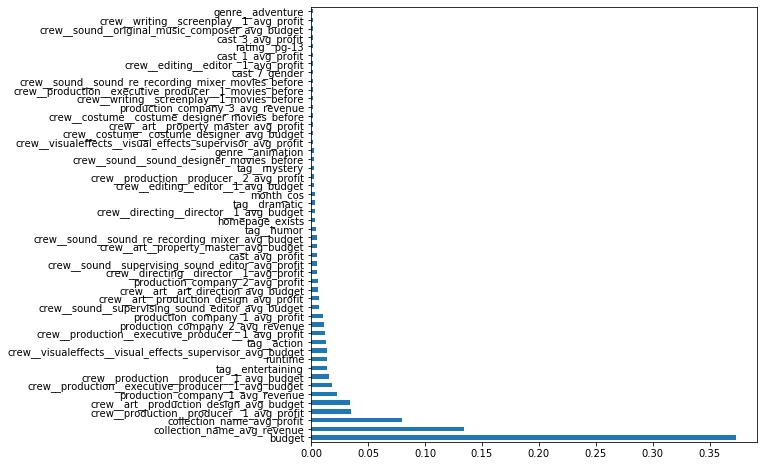

In [38]:
feat_importances = pd.Series(etr.feature_importances_, index=Xh_train.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.show()


ExtraTreesRegressor


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 

train
221776.41366374533
31963506.964474425
71548913.44522637
0.798707024028589
test
65665.64662079436
44343955.102259204
93008435.88299233
0.625424417705418
^^^^^^^^^^^^^^^^^^^^^^^^^^^^
etr
train


[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:    3.4s finished


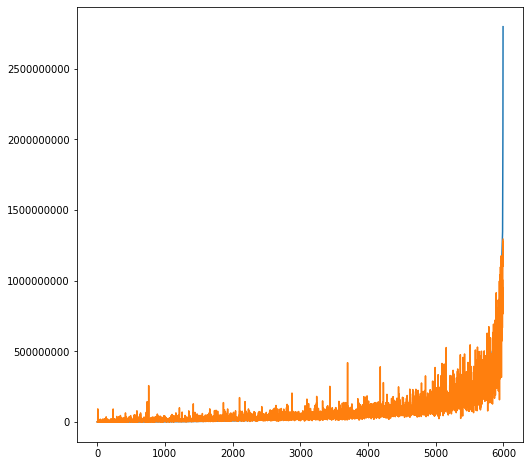

test


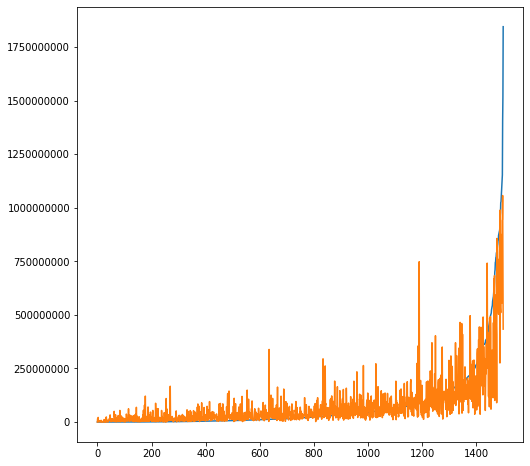

^^^^^^^^^^^^^^^^^^^^^^^^^^^^
etr
train


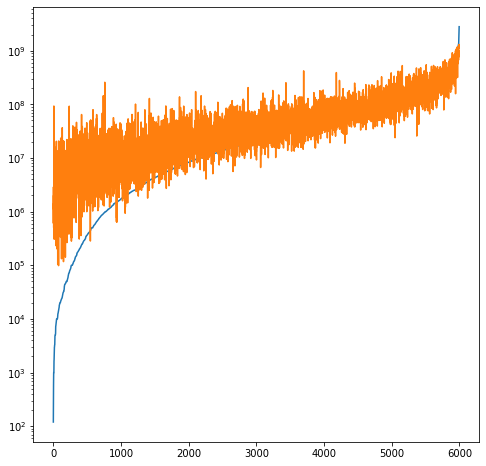

test


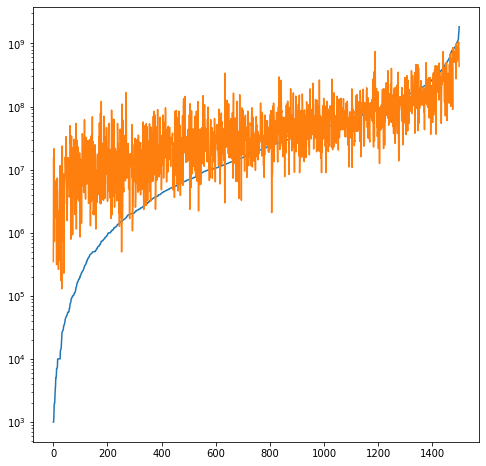

In [39]:
etr = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=10000, max_features=200, min_samples_leaf=10, min_samples_split=15)
res3 = predict(etr, "ExtraTreesRegressor", Xh_train, yh_train, Xh_test, yh_test)
print_sorted_actual_to_predicted_graphs({'etr': res3})
print_sorted_actual_to_predicted_graphs({'etr': res3}, train_log=True, test_log=True)

In [9]:
estimator = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=500, min_samples_leaf=5, min_samples_split=10)
selector = RFECV(estimator, verbose=10, n_jobs=-1)
selector = selector.fit(Xh_train, yh_train)

Fitting estimator with 225 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.1s finished


Fitting estimator with 224 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.1s finished


Fitting estimator with 223 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.9s finished


Fitting estimator with 222 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.9s finished


Fitting estimator with 221 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.4s finished


Fitting estimator with 220 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.7s finished


Fitting estimator with 219 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.3s finished


Fitting estimator with 218 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.5s finished


Fitting estimator with 217 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.5s finished


Fitting estimator with 216 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.4s finished


Fitting estimator with 215 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.3s finished


Fitting estimator with 214 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.5s finished


Fitting estimator with 213 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.4s finished


Fitting estimator with 212 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.4s finished


Fitting estimator with 211 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.9s finished


Fitting estimator with 210 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.7s finished


Fitting estimator with 209 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.1s finished


Fitting estimator with 208 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.0s finished


Fitting estimator with 207 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.0s finished


Fitting estimator with 206 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.9s finished


Fitting estimator with 205 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.1s finished


Fitting estimator with 204 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.7s finished


Fitting estimator with 203 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.8s finished


Fitting estimator with 202 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.6s finished


Fitting estimator with 201 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.6s finished


Fitting estimator with 200 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.5s finished


Fitting estimator with 199 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.5s finished


Fitting estimator with 198 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.5s finished


Fitting estimator with 197 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   1

In [10]:
import joblib
joblib.dump(selector, 'rfecv_selector_joblib_etr.sav')
import pickle
pickle.dump(selector, open('rfecv_selector_pickle_etr.sav', 'wb'))

In [24]:
print(f'num features: {selector.n_features_}')
print(f'\neatures mask: {selector.support_}')
print(f'\nfeatures ranking: {selector.ranking_}')

ind = selector.get_support()
not_ind = [not val for val in ind]
cols_include = list(Xh_train.columns[ind])
print(f'\ncols include \n{cols_include}')

cols_exclude = list(Xh_train.columns[not_ind])
print(f'\ncols exclude \n{cols_exclude}')

num features: 196

eatures mask: [ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True False False  True  True False False  True
 False False  True False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True

In [32]:
data_wo_minmaxscale = {}
process = Process(X_train, X_test, y_train, y_test, imputer='knn').skew_X().fill_nan()
data_wo_minmaxscale['X_train'], data_wo_minmaxscale['X_test'], data_wo_minmaxscale['y_train'], data_wo_minmaxscale['y_test'] = process.return_processed()


ExtraTreesRegressor


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 

train
282818.711958661
32957944.757544883
74184060.76665096
0.7911619203627
test
56677.18088283829
42729286.32040504
87046455.96143177
0.6179530693183746
^^^^^^^^^^^^^^^^^^^^^^^^^^^^
etr_wo_minmaxscale
train


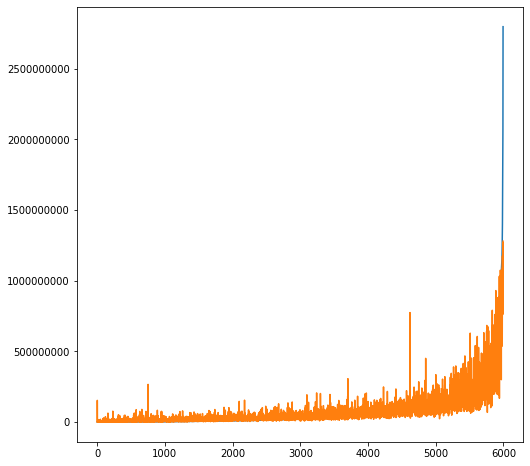

test


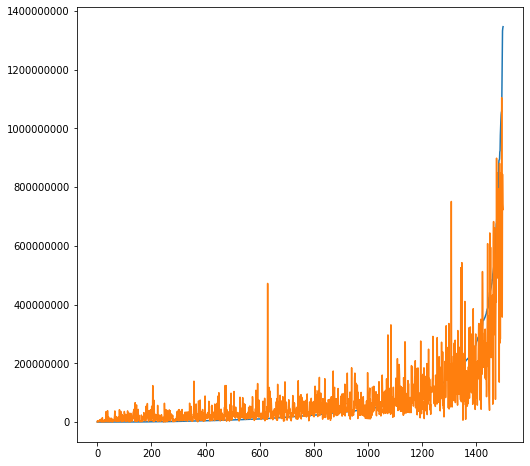

^^^^^^^^^^^^^^^^^^^^^^^^^^^^
etr_wo_minmaxscale
train


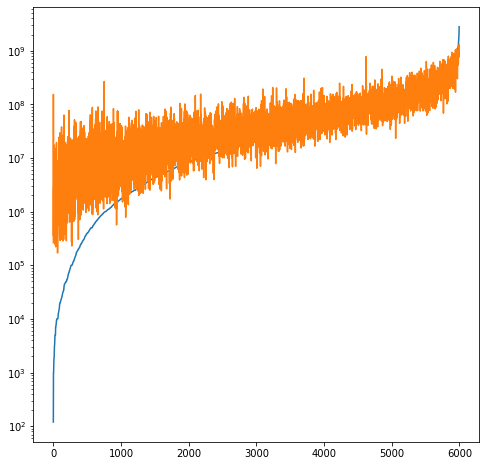

test


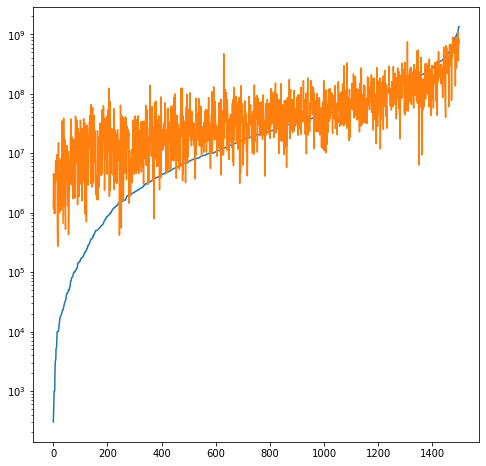

In [34]:
etr_wo_minmaxscale = ExtraTreesRegressor(n_jobs=-1, verbose=1, n_estimators=10000, max_features=200, min_samples_leaf=10, min_samples_split=25)
res_wo_minmaxscale = predict(etr_wo_minmaxscale, "ExtraTreesRegressor", 
               data_wo_minmaxscale['X_train'],  
               data_wo_minmaxscale['y_train'],
               data_wo_minmaxscale['X_test'],
               data_wo_minmaxscale['y_test'])
print_sorted_actual_to_predicted_graphs({'etr_wo_minmaxscale': res_wo_minmaxscale})
print_sorted_actual_to_predicted_graphs({'etr_wo_minmaxscale': res_wo_minmaxscale}, train_log=True, test_log=True)

In [36]:
data_skew_y = {}
process_skew_y = Process(X_train, X_test, y_train, y_test, imputer='knn').skew_X().skew_y().fill_nan()
data_skew_y['X_train'], data_skew_y['X_test'], data_skew_y['y_train'], data_skew_y['y_test'] = process_skew_y.return_processed()

In [37]:
etr_skew_y = ExtraTreesRegressor(n_jobs=-1, n_estimators=10000, max_features=200, min_samples_leaf=10, min_samples_split=25)
res_skew_y = predict(etr_skew_y, "ExtraTreesRegressor", 
               data_skew_y['X_train'],  
               data_skew_y['y_train'],
               data_skew_y['X_test'],
               data_skew_y['y_test'])
# print_sorted_actual_to_predicted_graphs({'etr_wo_minmaxscale': res_skew_y}, train_log=True, test_log=True)


ExtraTreesRegressor


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 

train
9572.260840943449
0.308503017588205
0.4061527687801599
0.8286073432983019
test
4151.976441349516
0.4444284128801991
0.5776401700159408
0.6158304073886878


[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:    2.3s finished


In [41]:
res_skew_y

{'res': {'train': {'mape': 9572.260840943449,
   'mae': 0.308503017588205,
   'rmse': 0.4061527687801599,
   'adj_r2': 0.8286073432983019},
  'test': {'mape': 4151.976441349516,
   'mae': 0.4444284128801991,
   'rmse': 0.5776401700159408,
   'adj_r2': 0.6158304073886878}},
 'predictions': {'train': array([-0.65879904, -0.30227536, -0.04461303, ..., -1.04704466,
          0.84054347, -0.90916066]),
  'test': array([-0.0559811 , -1.83983636, -0.51256312, ...,  0.90409964,
          1.00070103, -0.04629118])},
 'actual': {'train': array([-1.46534586, -1.19025028, -0.37411452, ..., -0.78299732,
          0.53269993, -1.11292462]),
  'test': array([-0.01962558, -1.04017289, -0.70932696, ...,  1.11126065,
          0.71865537, -0.1891145 ])}}

In [42]:
print_metrics('train', 
              process_skew_y.skew_y_inverse(res_skew_y['actual']['train']), 
              process_skew_y.skew_y_inverse(res_skew_y['predictions']['train']), 
              data_skew_y['X_train'].shape[1])
print_metrics('test', 
              process_skew_y.skew_y_inverse(res_skew_y['actual']['test']), 
              process_skew_y.skew_y_inverse(res_skew_y['predictions']['test']), 
              data_skew_y['X_test'].shape[1])

train
17746.203001308353
32421811.282424714
86157743.54752438
0.7183063100669085
test
11422.159822204903
40289749.552101195
95797522.27765085
0.5372748759925774


{'mape': 11422.159822204903,
 'mae': 40289749.552101195,
 'rmse': 95797522.27765085,
 'adj_r2': 0.5372748759925774}

^^^^^^^^^^^^^^^^^^^^^^^^^^^^
etr_skew_y
train


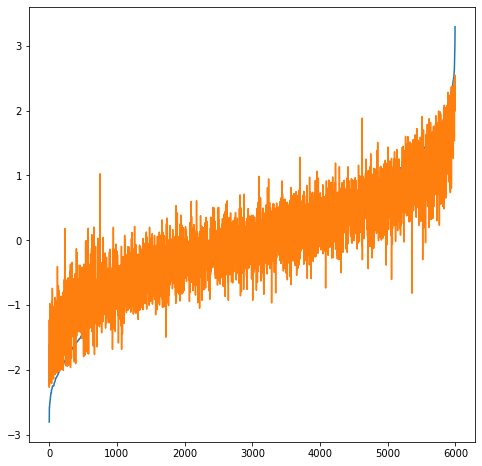

test


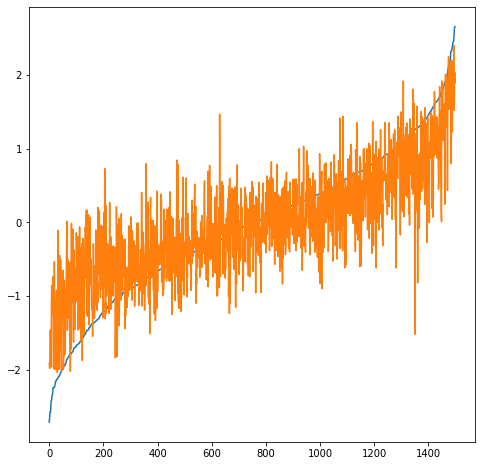

train real values log


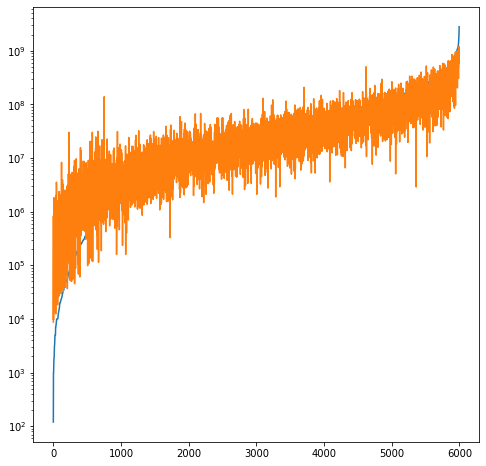

test real values log


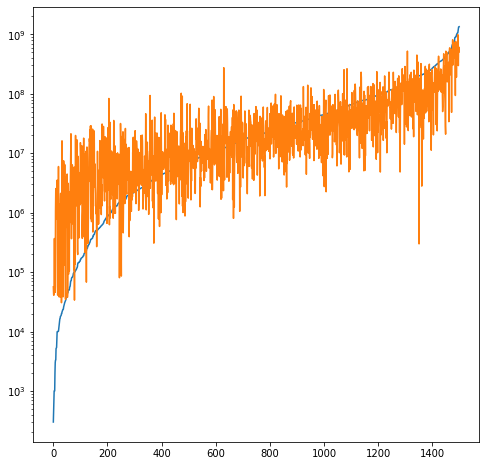

train real values


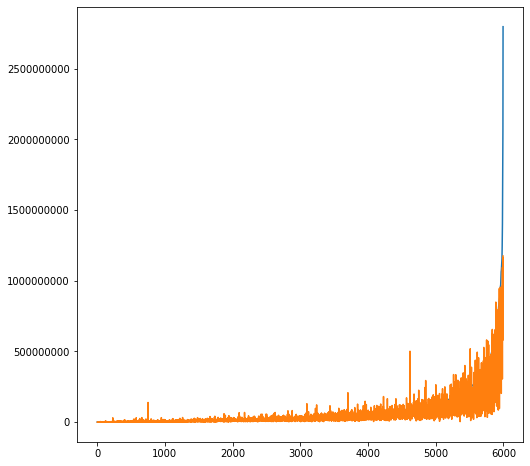

test real values


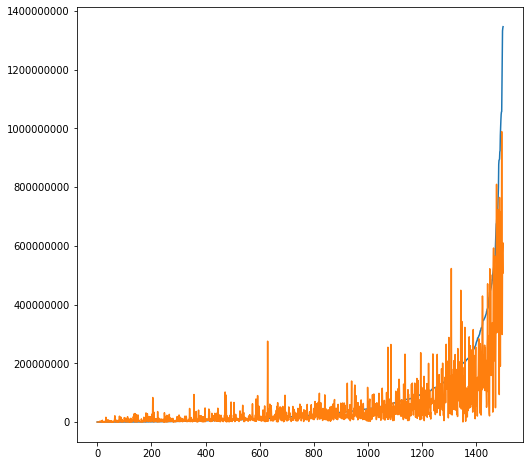

In [44]:
print_sorted_actual_to_predicted_graphs({'etr_skew_y': res_skew_y}, process = process_skew_y)

In [49]:
feat_importances = pd.Series(etr_skew_y.feature_importances_, index=data_skew_y['X_train'].columns)
# feat_importances.nlargest(50).plot(kind='barh')
# plt.show()

tag__alternate_reality                       0.000000000000000
tag__thought_provoking                       0.000000112064765
tag__philosophical                           0.000000163879619
tag__cruelty                                 0.000000535535264
tag__home_movie                              0.000000545887881
                                                  ...         
production_company_2_avg_revenue             0.023731225593127
crew__art__production_design_avg_budget      0.024540146498576
collection_name_avg_revenue                  0.049841371900322
production_company_1_avg_revenue             0.065643535466568
budget                                       0.491208990159230
Length: 225, dtype: float64

In [52]:
pprint(feat_importances.sort_values().to_string())

('tag__alternate_reality                                            '
 '0.000000000000000\n'
 'tag__thought_provoking                                            '
 '0.000000112064765\n'
 'tag__philosophical                                                '
 '0.000000163879619\n'
 'tag__cruelty                                                      '
 '0.000000535535264\n'
 'tag__home_movie                                                   '
 '0.000000545887881\n'
 'tag__depressing                                                   '
 '0.000000599288812\n'
 'tag__plot_twist                                                   '
 '0.000000814737274\n'
 'tag__sci_fi                                                       '
 '0.000000854071209\n'
 'genre__western                                                    '
 '0.000001671500878\n'
 'tag__storytelling                                                 '
 '0.000001763928912\n'
 'tag__absurd                                                       '
